In [202]:
import os
import pcapy as p
from scapy.all import *
import matplotlib.pyplot as plt

import pandas as pd

import struct
import numpy as np

In [203]:
#USB
import usb.core
import usb.util 
# Figures
import pandas as pd
import numpy as np
# Utilities
import json
import base64
import struct

In [208]:
    device = usb.core.find(idVendor=0x1921, idProduct=0xf001)
        # initialize device
    usb.util.dispose_resources(device)
    device.reset()
    # find first USBTMC interface
    IFS = []
    for cfg in device:
        for iface in cfg:
            #print(iface)
            IFS.append(iface)
            #print(" TORLOLOLO \n\n")


    try:
        old_cfg = device.get_active_configuration()
    except usb.core.USBError:
        # ignore exception if configuration is not set
        pass

    if old_cfg is not None and old_cfg.bConfigurationValue == cfg.bConfigurationValue:
        # already set to correct configuration

        # release kernel driver on USBTMC interface
        print("lol")
    else:
        # wrong configuration or configuration not set

        device.set_configuration(cfg)

    # claim interface
    for iface in IFS:
        print(" IFACE-> ")
        usb.util.claim_interface(device, iface)

        # don't need to set altsetting - USBTMC devices have 1 altsetting as per the spec

        # find endpoints
        for ep in iface:
            ep_dir = usb.util.endpoint_direction(ep.bEndpointAddress)
            ep_type = usb.util.endpoint_type(ep.bmAttributes)

            if (ep_type == usb.util.ENDPOINT_TYPE_BULK):
                if (ep_dir == usb.util.ENDPOINT_IN):
                    bulk_in_ep = ep
                elif (ep_dir == usb.util.ENDPOINT_OUT):
                    bulk_out_ep = ep
            elif (ep_type == usb.util.ENDPOINT_TYPE_INTR):
                if (ep_dir == usb.util.ENDPOINT_IN):
                    interrupt_in_ep = ep
            #print(ep) 
        try:
            device.ctrl_transfer(bmRequestType=64,bRequest=187, wValue =0x0000)
            print("Working")
        except:
            print("Not working")

lol
 IFACE-> 
Working


In [79]:
print(cfg)

  CONFIGURATION 1: 500 mA ==================================
   bLength              :    0x9 (9 bytes)
   bDescriptorType      :    0x2 Configuration
   wTotalLength         :   0x20 (32 bytes)
   bNumInterfaces       :    0x1
   bConfigurationValue  :    0x1
   iConfiguration       :    0x0 
   bmAttributes         :   0x80 Bus Powered
   bMaxPower            :   0xfa (500 mA)
    INTERFACE 0: Vendor Specific ===========================
     bLength            :    0x9 (9 bytes)
     bDescriptorType    :    0x4 Interface
     bInterfaceNumber   :    0x0
     bAlternateSetting  :    0x0
     bNumEndpoints      :    0x2
     bInterfaceClass    :   0xff Vendor Specific
     bInterfaceSubClass :    0x0
     bInterfaceProtocol :    0x0
     iInterface         :    0x0 
      ENDPOINT 0x82: Bulk IN ===============================
       bLength          :    0x7 (7 bytes)
       bDescriptorType  :    0x5 Endpoint
       bEndpointAddress :   0x82 IN
       bmAttributes     :    0x2 Bulk
   

In [80]:
data = "data/test1.pcapng"

In [81]:
packets = rdpcap(data)
Config = []
IMGS = []
IMGSsmol = []
idxImags = []
start = 0
ix = 1
for k in packets:
    k = k[Raw].load
    if k[8] == 0x53: # URB submit
        if k[9] == 0x02: # URB submit
            TYPE = "URB_CONTROL"
        elif k[9] == 0x03: # BULK
            TYPE = "BULK"
        EP = k[10] # EP
        if EP == 0:
            SENS ="OUT"
        else:
            SENS = "IN"
        if TYPE == "BULK":
            sizeRequested = k[33]*256+k[32] 
            Config.append({'ID': ix,"Sens":SENS,"TYPE":TYPE,"EP":k[10],"sizeRequested":sizeRequested})
        else:
            bmRequestType = k[40]
            bmRequest = k[41]
            bmValue  =  256*k[43]+k[42] 
            bmIndex  = k[44]+256*k[45]  
            bmLength =  k[46:48]  

            #print(ix,hex(bmRequestType),bmRequest,hex(bmValue),bmIndex,bmLength,TYPE,SENS,hex(EP))
            Config.append({'ID': ix,"Sens":SENS,"TYPE":TYPE,"EP":k[10],"bmRequestType":bmRequestType,
                           "bmRequest":bmRequest,"bmValue":bmValue,"bmIndex":bmIndex,"bmLength":bmLength
                      })
            
    if k[8] == 0x43: # URB receive
        if 0:
            if (len(k) == 65):
                print(ix,hex(k[-1]))
            if (len(k) == 66):
                print(ix,hex(k[-1]+256*k[-2]  ))
                
    if (k[8] == 0x43) & (k[10] == 0x86): # URB receive  
        if len(k) > 20000:
            IMGS.append(k[64:])
            #print(ix)
            idxImags.append(str(ix)+"full")
        else:
            IMGSsmol.append(k[64:])
            idxImags.append(str(ix)+"short")
    
    ix +=1

In [130]:
df = pd.DataFrame(Config) 
df.drop_duplicates(subset=["bmRequestType","bmRequest","bmValue","sizeRequested"]).sort_values(by=["bmRequestType","bmRequest","bmValue"])

,ID,Sens,TYPE,EP,bmRequestType,bmRequest,bmValue,bmIndex,bmLength,sizeRequested
898,1797,OUT,URB_CONTROL,0,64.0,164.0,0.0,0.0,b'\x00\x00',NaN
28,57,OUT,URB_CONTROL,0,64.0,183.0,0.0,0.0,b'\x00\x00',NaN
23,47,OUT,URB_CONTROL,0,64.0,184.0,3.0,0.0,b'\x00\x00',NaN
899,1799,OUT,URB_CONTROL,0,64.0,186.0,0.0,0.0,b'\x00\x00',NaN
0,1,OUT,URB_CONTROL,0,64.0,187.0,0.0,0.0,b'\x00\x00',NaN
906,1811,OUT,URB_CONTROL,0,64.0,208.0,0.0,0.0,b'\x00\x00',NaN
15,31,OUT,URB_CONTROL,0,64.0,209.0,0.0,0.0,b'\x00\x00',NaN
902,1805,OUT,URB_CONTROL,0,64.0,213.0,0.0,0.0,b'\x00\x00',NaN
16,33,OUT,URB_CONTROL,0,64.0,214.0,0.0,0.0,b'\x00\x00',NaN
19,39,OUT,URB_CONTROL,0,64.0,216.0,24.0,0.0,b'\x00\x00',NaN


In [131]:
7168.0 -7250.0

-82.0

# Replays

In [83]:
EP = []
for ep in iface:
    ep_dir = usb.util.endpoint_direction(ep.bEndpointAddress)
    ep_type = usb.util.endpoint_type(ep.bmAttributes)
    EP.append(ep)
    print(ep)

      ENDPOINT 0x82: Bulk IN ===============================
       bLength          :    0x7 (7 bytes)
       bDescriptorType  :    0x5 Endpoint
       bEndpointAddress :   0x82 IN
       bmAttributes     :    0x2 Bulk
       wMaxPacketSize   :  0x200 (512 bytes)
       bInterval        :    0x0
      ENDPOINT 0x86: Bulk IN ===============================
       bLength          :    0x7 (7 bytes)
       bDescriptorType  :    0x5 Endpoint
       bEndpointAddress :   0x86 IN
       bmAttributes     :    0x2 Bulk
       wMaxPacketSize   :  0x200 (512 bytes)
       bInterval        :    0x0


In [132]:
for index, row in df.iterrows():
    if  row["Sens"] == "OUT":
        #print(row["ID"])
        bmRT = int(row["bmRequestType"])
        bmR = int(row["bmRequest"])
        wV = int(row["bmValue"])
        wI = int(row["bmIndex"])
        PL = row["bmLength"]
        print(bmRT,bmR,wV,wI,PL)
        device.ctrl_transfer(bmRequestType= bmRT,bRequest= bmR, wValue= wV, wIndex= wI , data_or_wLength=  PL)
print("Done")

data = []



64 187 0 0 b'\x00\x00'
64 222 0 0 b'\x00\x00'
64 227 0 0 b'\x00\x00'
64 209 0 0 b'\x00\x00'
64 214 0 0 b'\x00\x00'
64 187 0 0 b'\x00\x00'
64 216 24 0 b'\x00\x00'
64 222 0 0 b'\x00\x00'
64 224 0 0 b'\x00\x00'
64 184 3 0 b'\x00\x00'
64 218 1 0 b'\x00\x00'
64 216 24 0 b'\x00\x00'
64 183 0 0 b'\x00\x00'
64 224 0 0 b'\x00\x00'
64 184 3 0 b'\x00\x00'
64 218 1 0 b'\x00\x00'
64 216 24 0 b'\x00\x00'
64 222 0 0 b'\x00\x00'
64 224 0 0 b'\x00\x00'
64 184 3 0 b'\x00\x00'
64 218 1 0 b'\x00\x00'
64 216 24 0 b'\x00\x00'
64 222 0 0 b'\x00\x00'
64 222 0 0 b'\x00\x00'
64 222 0 0 b'\x00\x00'
64 224 0 0 b'\x00\x00'
64 184 3 0 b'\x00\x00'
64 218 1 0 b'\x00\x00'
64 216 24 0 b'\x00\x00'
64 224 0 0 b'\x00\x00'
64 184 3 0 b'\x00\x00'
64 218 1 0 b'\x00\x00'
64 216 24 0 b'\x00\x00'
64 224 0 0 b'\x00\x00'
64 184 3 0 b'\x00\x00'
64 218 1 0 b'\x00\x00'
64 216 24 0 b'\x00\x00'
64 224 0 0 b'\x00\x00'
64 184 3 0 b'\x00\x00'
64 218 1 0 b'\x00\x00'
64 216 24 0 b'\x00\x00'
64 164 0 0 b'\x00\x00'
64 186 0 0 b'\x00\x00'
64 

In [97]:
device.ctrl_transfer(bmRequestType= 64,bRequest= 164, wValue= 0, wIndex= 0 , data_or_wLength=  "\x00\x00")
device.ctrl_transfer(bmRequestType= 64,bRequest= 208, wValue= 0, wIndex= 0 , data_or_wLength=  "\x00\x00")


2

In [99]:
device.ctrl_transfer(bmRequestType= 64,bRequest= 164, wValue= 0, wIndex= 0 , data_or_wLength=  "\x00\x00")


2

2

In [167]:
EP

[<ENDPOINT 0x82: Bulk IN>, <ENDPOINT 0x86: Bulk IN>]

In [190]:
device.ctrl_transfer(bmRequestType= 64,bRequest= 213, wValue= 0, wIndex= 0 , data_or_wLength=  "\x00\x00") # démarre le moteur


2

In [177]:
device.ctrl_transfer(bmRequestType= 64,bRequest= 209, wValue= 0, wIndex= 0 , data_or_wLength=  "\x00\x00") # ends shooting


2

In [191]:
data = []
data2 = []
i = 0
while i < 4*2048*120//512: # 2 because we're reading 2bytes words
    data.append(EP[0].read(0x200))
    data2.append(EP[1].read(0x200)) 
    i += 1

In [192]:
device.ctrl_transfer(bmRequestType= 64,bRequest= 208, wValue= 0, wIndex= 0 , data_or_wLength=  "\x00\x00") #starts shooting
device.ctrl_transfer(bmRequestType= 64,bRequest= 214, wValue= 0, wIndex= 0 , data_or_wLength=  "\x00\x00") # stoppe le moteur


2

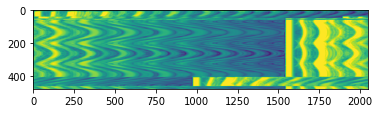

In [194]:
plt.imshow(np.array(data).reshape(2*240, 2048))

In [205]:
Config = []
Config.append({"bmRequest":187,"bmValue": 0})
Config.append({"bmRequest":222,"bmValue": 0})
Config.append({"bmRequest":227,"bmValue": 0})
Config.append({"bmRequest":227,"bmValue": 0})
Config.append({"bmRequest":216,"bmValue":24})
Config.append({"bmRequest":187,"bmValue": 0})

Config.append({"bmRequest":224,"bmValue": 0})
Config.append({"bmRequest":184,"bmValue": 3})
Config.append({"bmRequest":218,"bmValue": 1})
Config.append({"bmRequest":216,"bmValue":24})

Config.append({"bmRequest":164,"bmValue": 0})
Config.append({"bmRequest":186,"bmValue": 0})
Config.append({"bmRequest":228,"bmValue": 1})
Config.append({"bmRequest":213,"bmValue": 0})

Config.append({"bmRequest":164,"bmValue": 0})
Config.append({"bmRequest":208,"bmValue": 0})

dfShort = pd.DataFrame(Config) 
dfShort

,bmRequest,bmValue
0,187,0
1,222,0
2,227,0
3,227,0
4,216,24
5,187,0
6,224,0
7,184,3
8,218,1
9,216,24


In [222]:
print(dfShort.bmValue.to_list())

[0, 0, 0, 0, 24, 0, 0, 3, 1, 24, 0, 0, 1, 0, 0, 0]


In [209]:
EP = []
for ep in iface:
    ep_dir = usb.util.endpoint_direction(ep.bEndpointAddress)
    ep_type = usb.util.endpoint_type(ep.bmAttributes)
    EP.append(ep)
    print(ep)
    
for index, row in dfShort.iterrows():
    bmR = int(row["bmRequest"])
    wV = int(row["bmValue"])
    device.ctrl_transfer(bmRequestType= 64,bRequest= bmR, wValue= wV, wIndex= 0 , data_or_wLength=  "\x00\x00") 
print("Done")

data = []



    data = []
    data2 = []
    i = 0
    while i < 24*2048*120//512: # 2 because we're reading 2bytes words
        data.append(EP[0].read(0x200))
        data2.append(EP[1].read(0x200)) 
        i += 1
    
device.ctrl_transfer(bmRequestType= 64,bRequest= 208, wValue= 0, wIndex= 0 , data_or_wLength=  "\x00\x00") #starts shooting
device.ctrl_transfer(bmRequestType= 64,bRequest= 214, wValue= 0, wIndex= 0 , data_or_wLength=  "\x00\x00") # stoppe le moteur


      ENDPOINT 0x82: Bulk IN ===============================
       bLength          :    0x7 (7 bytes)
       bDescriptorType  :    0x5 Endpoint
       bEndpointAddress :   0x82 IN
       bmAttributes     :    0x2 Bulk
       wMaxPacketSize   :  0x200 (512 bytes)
       bInterval        :    0x0
      ENDPOINT 0x86: Bulk IN ===============================
       bLength          :    0x7 (7 bytes)
       bDescriptorType  :    0x5 Endpoint
       bEndpointAddress :   0x86 IN
       bmAttributes     :    0x2 Bulk
       wMaxPacketSize   :  0x200 (512 bytes)
       bInterval        :    0x0
Done


2

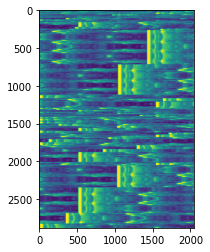

In [213]:
plt.imshow(np.array(data).reshape(2880, 2048))

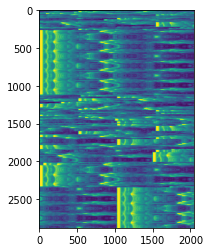

In [214]:
plt.imshow(np.array(data2).reshape(2880, 2048))

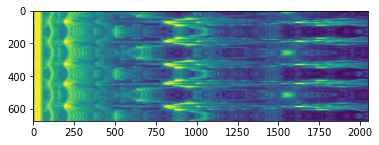

In [215]:
plt.imshow(np.array(data2).reshape(2880, 2048)[350:1024])

In [216]:
IMGS = np.array(data2).reshape(2880, 2048)

In [219]:
np.savez("imagedata2",data=data2)